In [2]:
import pandas as pd
import os
from src.utils import get_root_dir

### This Notebook will be used to test models for time-series forecasting on crime data

In [4]:
get_root_dir()

'/home/jamie/code/JamieW365/londoncrime'

In [6]:
df_crime = pd.read_csv(os.path.join(get_root_dir(), 'data/processed/final.csv'))
df_crime.head()

,Major,Minor,Borough,Date,Count,Population
0,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-04-01,6.0,182838
1,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-05-01,5.0,182838
2,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-06-01,11.0,182838
3,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-07-01,10.0,182838
4,Arson and Criminal Damage,Arson,Barking and Dagenham,2010-08-01,6.0,182838


In [24]:
df_crime['Count_Per_1000'] = df_crime['Count'] / (df_crime['Population'] / 1000)

In [28]:
total_crime_trend = df_crime.groupby('Date').sum(numeric_only=True)['Count_Per_1000']
total_crime_trend

Date
2010-04-01    268.322545
2010-05-01    274.519513
2010-06-01    277.427047
2010-07-01    281.972314
2010-08-01    261.862011
                 ...    
2023-07-01    273.811522
2023-08-01    262.543980
2023-09-01    263.757539
2023-10-01    280.749514
2023-11-01    271.461315
Name: Count_Per_1000, Length: 164, dtype: float64

<Axes: title={'center': 'Total Crime'}, xlabel='Date'>

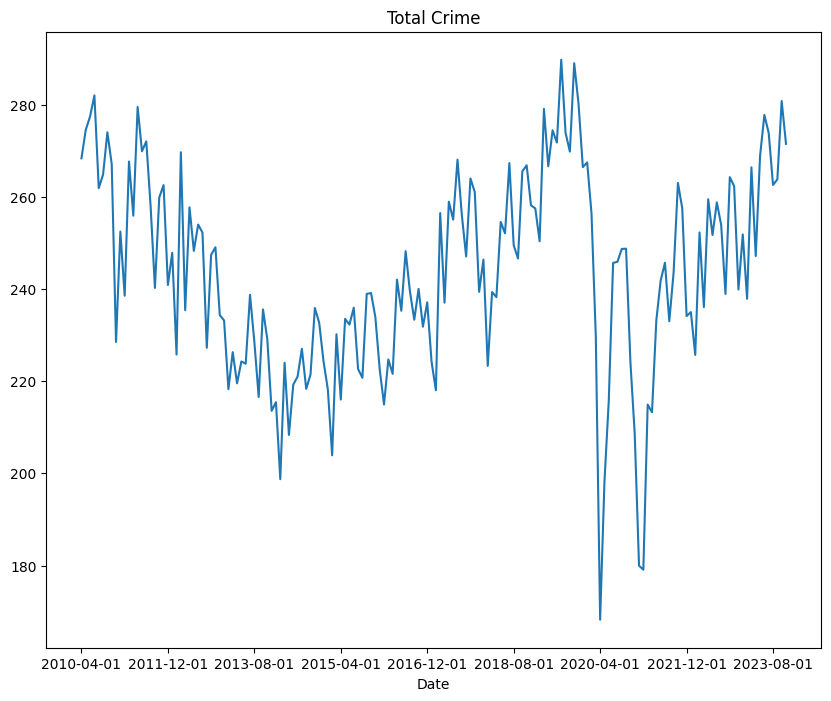

In [30]:
total_crime_trend.plot(figsize=(10,8),
                       title='Total Crime')

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

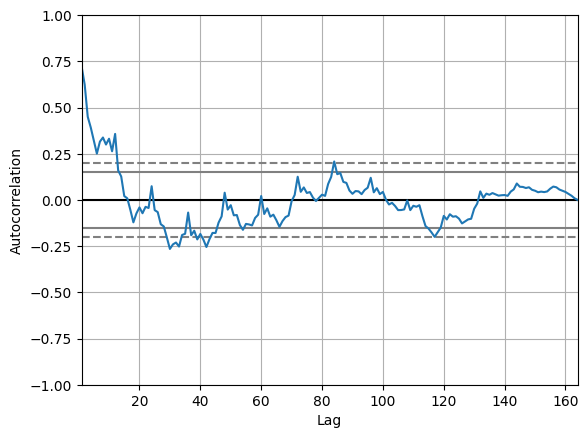

In [31]:
pd.plotting.autocorrelation_plot(total_crime_trend)

In [32]:
from statsmodels.tsa.arima.model import ARIMA

In [33]:
model = ARIMA(total_crime_trend, order=(15,1,0))
model_fit = model.fit()
print(model_fit.summary())

/home/jamie/code/JamieW365/londoncrime/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/jamie/code/JamieW365/londoncrime/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/jamie/code/JamieW365/londoncrime/env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         Count_Per_1000   No. Observations:                  164
Model:                ARIMA(15, 1, 0)   Log Likelihood                -632.902
Date:                Tue, 02 Apr 2024   AIC                           1297.805
Time:                        19:35:01   BIC                           1347.305
Sample:                    04-01-2010   HQIC                          1317.901
                         - 11-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1455      0.087     -1.669      0.095      -0.316       0.025
ar.L2         -0.1505      0.084     -1.786      0.074      -0.316       0.015
ar.L3         -0.1802      0.093     -1.935      0.0